<a href="https://colab.research.google.com/github/SagarMeti5/Loan-Survival-Analysis-Time-to-Default-Prediction/blob/main/practice4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lifelines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter

import warnings
warnings.filterwarnings('ignore')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Load only first 50,000 rows to avoid RAM issues
file_path = '/content/drive/MyDrive/accepted_2007_to_2018Q4.csv'
df = pd.read_csv(file_path, nrows=50000)

print("Shape of sampled dataset:", df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of sampled dataset: (50000, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])

df['duration'] = ((df['last_pymnt_d'] - df['issue_d']).dt.days)/30

df['event_observed'] = df['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)

df = df.dropna(subset=['duration', 'event_observed'])
print("After cleaning:", df.shape)


After cleaning: (49966, 153)


In [6]:
from sklearn.preprocessing import LabelEncoder

features = ['term', 'grade', 'sub_grade', 'home_ownership', 'purpose',
            'emp_length', 'loan_amnt', 'int_rate', 'annual_inc']

df_model = df[features + ['duration', 'event_observed']].copy()

le = LabelEncoder()
for col in ['term', 'grade', 'sub_grade', 'home_ownership', 'purpose', 'emp_length']:
    df_model[col] = le.fit_transform(df_model[col].astype(str))

df_model.fillna(df_model.median(), inplace=True)

df_model.head()


,term,grade,sub_grade,home_ownership,purpose,emp_length,loan_amnt,int_rate,annual_inc,duration,event_observed
0,0,2,13,1,2,1,3600.0,13.99,55000.0,37.566667,0
1,0,2,10,1,10,1,24700.0,11.99,65000.0,6.100000,0
2,1,1,8,1,3,1,20000.0,10.78,63000.0,18.266667,0
3,1,2,14,1,2,1,35000.0,14.85,110000.0,38.600000,0
4,1,5,25,1,5,3,10400.0,22.45,104433.0,7.100000,0


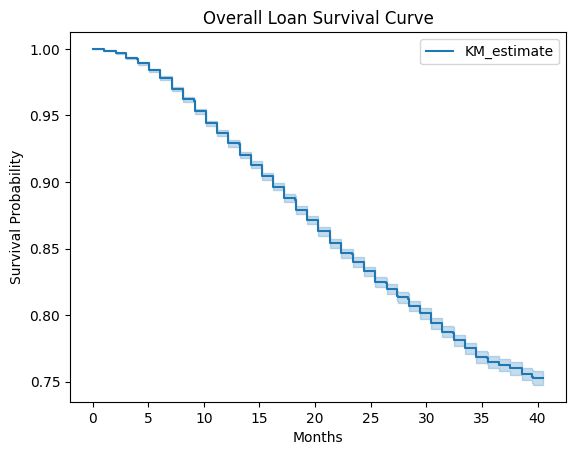

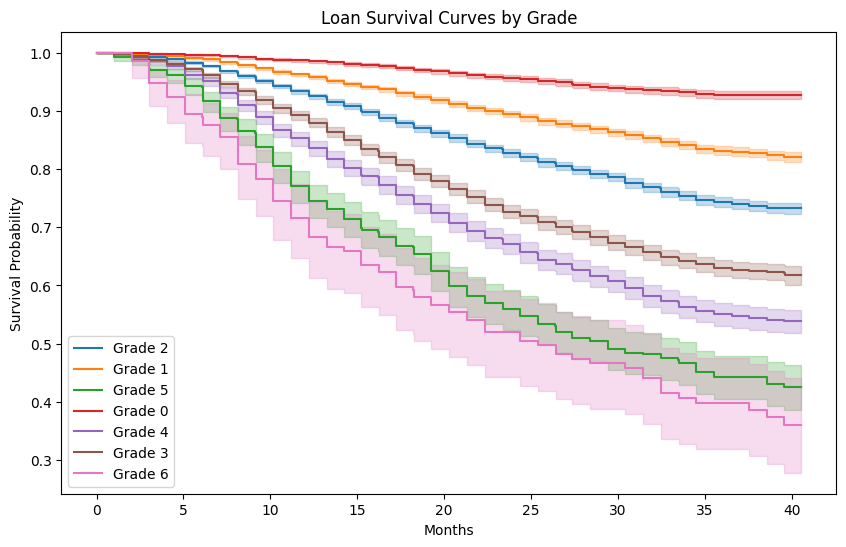

In [7]:
kmf = KaplanMeierFitter()

kmf.fit(df_model['duration'], event_observed=df_model['event_observed'])
kmf.plot_survival_function()
plt.title("Overall Loan Survival Curve")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()

plt.figure(figsize=(10,6))
for grade in df_model['grade'].unique():
    kmf.fit(df_model[df_model['grade']==grade]['duration'],
            event_observed=df_model[df_model['grade']==grade]['event_observed'],
            label=f'Grade {grade}')
    kmf.plot_survival_function()
plt.title("Loan Survival Curves by Grade")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()


<lifelines.CoxPHFitter: fitted with 49966 total observations, 40973 right-censored observations>
             duration col = 'duration'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 49966
number of events observed = 8993
   partial log-likelihood = -91996.36
         time fit was run = 2025-09-28 06:42:18 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
term           -0.20      0.82      0.03           -0.25           -0.14                0.78                0.87
grade          -0.06      0.94      0.04           -0.13            0.01                0.88                1.01
sub_grade       0.09      1.10      0.02            0.06            0.13                1.06                1.14
home_ownership  0.10      1.11      0.01            0.08            0.12                1.08                1.13
purpose        -0.02      0.98      0.01           -0.03           -0.01                0.97                0.99
emp_length      0.01      1.01      0.00            0.00            0.01                1.00                1.01
loan_amnt       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
int_rate        0.02      1.02      0.02           -0.02            0.07                0.98                1.07
annual_inc     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                cmp to     z      p  -log2(p)
covariate                                    
term              0.00 -7.28 <0.005     41.40
grade             0.00 -1.60   0.11      3.20
sub_grade         0.00  5.70 <0.005     26.29
home_ownership    0.00  8.80 <0.005     59.29
purpose           0.00 -3.40 <0.005     10.53
emp_length        0.00  2.26   0.02      5.39
loan_amnt         0.00  0.81   0.42      1.25
int_rate          0.00  1.00   0.32      1.66
annual_inc        0.00 -2.07   0.04      4.71
---
Concordance = 0.69
Partial AIC = 184010.71
log-likelihood ratio test = 3551.22 on 9 df
-log2(p) of ll-ratio test = inf

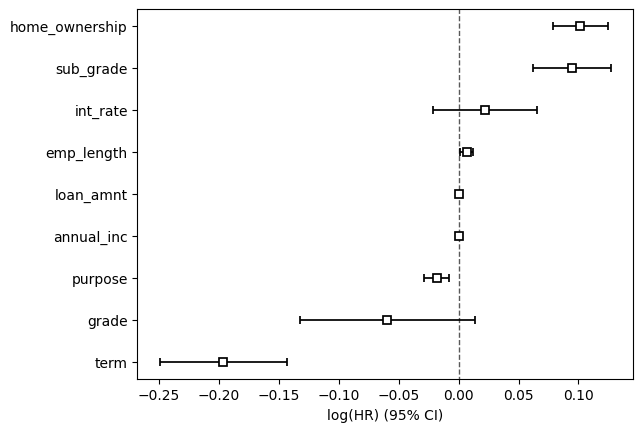

In [8]:
cph = CoxPHFitter()

cph.fit(df_model, duration_col='duration', event_col='event_observed')

cph.print_summary()

cph.plot()
plt.show()


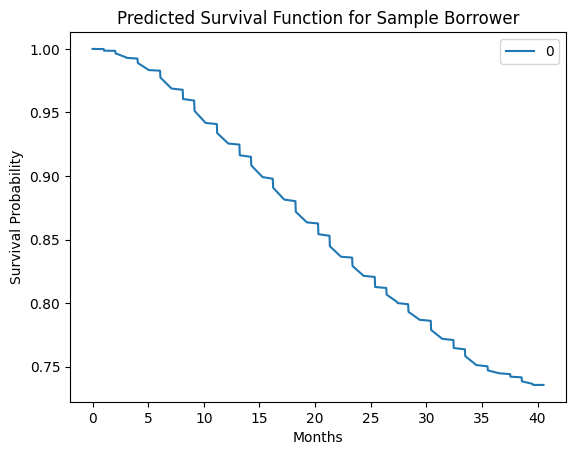

In [9]:
sample = df_model.iloc[0:1, :-2]  # exclude duration & event

survival_pred = cph.predict_survival_function(sample)
survival_pred.plot()
plt.title("Predicted Survival Function for Sample Borrower")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()
